### Sk-learn Classification Script

In [1]:
#Import necessary libraries
import os
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.features import geometry_mask
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import autosklearn.classification
import matplotlib.pyplot as plt

### Load the Image

In [19]:
file_path = "/mnt/c/Users/User/Desktop/Master_Thesis_Christobal/Sentinel_Images/Wet_RGBNIR/Kaza_NDVI_Wet_season_Image.tif"
shapefile_path = "/mnt/c/Users/User/Desktop/Master_Thesis_Christobal/Shapefiles/training_data_kaza.shp"
output_dir = "/mnt/c/Users/User/Desktop/Master_Thesis_Christobal/Results"

In [3]:
if not os.path.exists(file_path):
    print('File does not exist:', file_path)
else:
    with rasterio.open(file_path) as src:
        image = src.read() #read all bands as a numpy array
        profile = src.profile #saves geospatial profile for later re-projection
        transform = src.transform # transforms mapping coordinates to pixels
        crs = src.crs # coordinate reference system (crs) 
        print('Image dimensions (Bands, Height, Width):', image.shape)

Image dimensions (Bands, Height, Width): (9, 1678, 2202)


### Load the Training Data

In [4]:
shapefile = gpd.read_file(shapefile_path)
if shapefile.crs != crs:
    shapefile = shapefile.to_crs(crs) # ensures crs matches that of the raster image

##### Extract the labels and their corresponding geometrics

In [5]:
labels = shapefile['Class'] # select column
geometries = shapefile.geometry

##### Extract training data from raster using shapefile

In [6]:
training_data = []
training_labels = []

for geometry, label in zip(geometries, labels):
    # create mask for the geometry
    mask = geometry_mask([geometry], transform=transform, invert=True, out_shape=(image.shape[1], image.shape[2]))

    # Extract pixel values within the geometry
    pixels = image[:, mask].T # Shape: (num_pixels, num_bands)
    training_data.append(pixels)
    training_labels.extend([label] * len(pixels)) # Repeat the label for all pixels

In [7]:
# Flatten training data into a single array
training_data = np.vstack(training_data)
training_labels = np.array(training_labels)

##### Prepare the data for classification

In [8]:
#Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(training_data, training_labels, test_size=0.3, random_state=42)

print(f'Training samples: {len(X_train)}, Testing samples: {len(X_test)}')

Training samples: 113, Testing samples: 49


##### Perform Classifcation using auto-sklearn

In [10]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600, # 1 hour time limit
    per_run_time_limit=300, # 5 minutes per model
    ensemble_size=50
    #ensemble_kwargs = {'ensemble_size': 50}
)

print(' Training AutoSklearn Classifier...')
# Fit the AutoSklearn Classifier
automl.fit(X_train, y_train)

/tmp/ipykernel_86562/4145568198.py:1: DeprecationWarning: `ensemble_size` has been deprecated, please use `ensemble_kwargs = {'ensemble_size': 50}`. Inserting `ensemble_size` into `ensemble_kwargs` for now. `ensemble_size` will be removed in auto-sklearn 0.16.
  automl = autosklearn.classification.AutoSklearnClassifier(


 Training AutoSklearn Classifier...


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      ensemble_kwargs={'ensemble_size': 50}, ensemble_size=50,
                      per_run_time_limit=300)

##### Save Auto-sklearn report

In [23]:
# Print the results
print('Auto-sklearn training complete.')

# Save best model summary
best_model_summary = automl.show_models()
# print('Best model:', best_model_summary)
# convert the dictionary to formatted string
best_model_summary_str = str(best_model_summary)

# Save it as a text file
with open("best_model_summary.txt", "w") as file:
    file.write(best_model_summary_str)
print("Best model summary saved to 'best_model_summary.txt'")

# Save individual models with their scores
models_with_scores = automl.leaderboard(
    detailed=True, sort_by='cost', ensemble_only=False
)
# print('Models leaderboard:')
# print(models_with_scores)

# Save leaderboard to a csv for comparison
models_with_scores.to_csv("autosklearn_leaderboard.csv", index=False)
print("Leaderboard saved to 'autosklearn_leaderboard.csv'")

Auto-sklearn training complete.
Best model summary saved to 'best_model_summary.txt'
Leaderboard saved to 'autosklearn_leaderboard.csv'


##### Evaluate the Model

In [12]:
print('Evaluating the Model...')
y_pred = automl.predict(X_test)

Evaluating the Model...


In [25]:
# Generate and save classification report
classification_report_str = classification_report(y_test, y_pred)
print(classification_report_str)

# Save classification report to the text file
with open("classification_report.txt", "w") as file:
    file.write(classification_report_str)
print("Classification report saved to 'classification_report.txt'")

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.93      1.00      0.96        13

    accuracy                           0.98        49
   macro avg       0.96      0.99      0.97        49
weighted avg       0.98      0.98      0.98        49

Classification report saved to 'classification_report.txt'


##### Apply the Model to the entire image

In [14]:
# Reshape the image into samples (rows = pixels, column = bands)
bands, height, width = image.shape
data = image.reshape(bands, height * width).T

In [15]:
# Predict the class for all valid pixels
predictions = automl.predict(data)

In [16]:
# Reconstruct the Classified image
classified_image = predictions.reshape(height, width)

##### Visualize the results

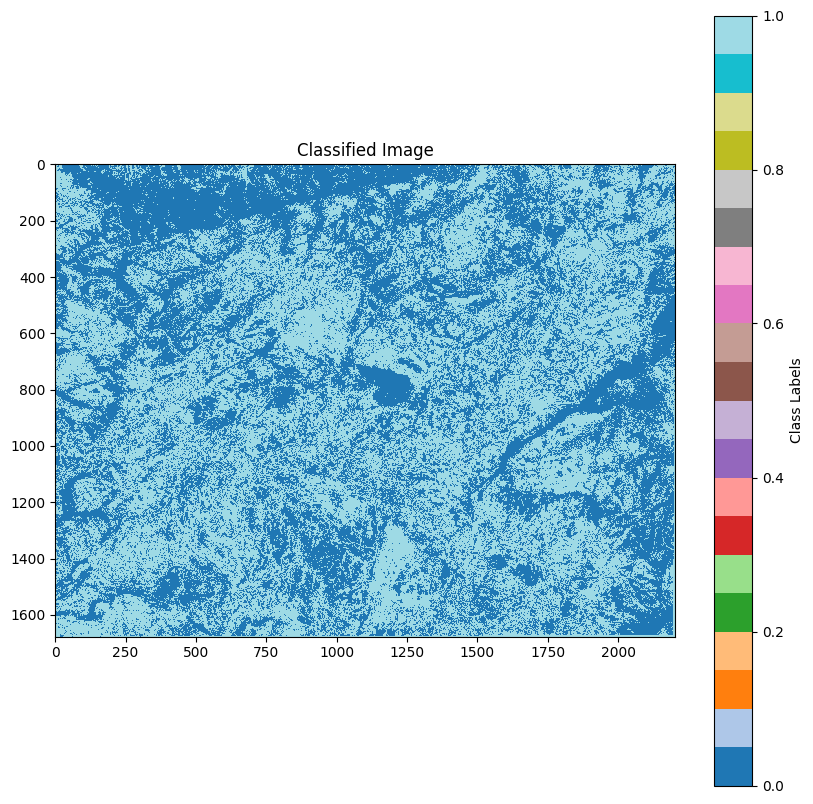

In [17]:
plt.figure(figsize=(10, 10))
plt.title('Classified Image')
plt.imshow(classified_image, cmap='tab20', interpolation='nearest')
plt.colorbar(label='Class Labels')
plt.show()

##### Save the classified image as a GeoTiff file

In [18]:
output_path = "/mnt/c/Users/User/Desktop/Master_Thesis_Christobal/Results/classified_image.tif"
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=classified_image.dtype,
    crs=profile['crs'],
    transform=profile['transform']
) as dst:
    dst.write(classified_image, 1)

print(f"Classified image saved to: {output_path}")

Classified image saved to: /mnt/c/Users/User/Desktop/Master_Thesis_Christobal/Results/classified_image.tif


##### Generate the Error Matrices

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Save confusion matrix
np.savetxt("confusion_matrix.csv", conf_matrix, delimiter=",", fmt='%d')
print("Confusion matrix saved to 'confusion_matrix.csv'")

In [ ]:
# Total Accuracy
total_accuracy = accuracy_score(y_test, y_pred)
print(f"Total Accuracy: {total_accuracy:.4f}")

# Producer's Accuracy (Recall per class)
producers_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
print("Producer's Accuracy (per class):", producers_accuracy)

# User's Accuracy (Precision per class)
users_accuracy = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
print("User's Accuracy (per class):", users_accuracy)

# Kappa Coefficient
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Kappa Coefficient: {kappa:.4f}")


In [ ]:
# Save metrics to a text file
with open("validation_metrics.txt", "w") as file:
    file.write(f"Total Accuracy: {total_accuracy:.4f}\n")
    file.write(f"Kappa Coefficient: {kappa:.4f}\n")
    file.write("Producer's Accuracy (per class):\n")
    file.write(", ".join([f"{pa:.4f}" for pa in producers_accuracy]) + "\n")
    file.write("User's Accuracy (per class):\n")
    file.write(", ".join([f"{ua:.4f}" for ua in users_accuracy]) + "\n")
print("Validation metrics saved to 'validation_metrics.txt'")